## Libs

In [2]:
import pandas as pd
import numpy as np 
import joblib
import sys

import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score
from sklearn.compose import ColumnTransformer
from fast_ml.model_development import train_valid_test_split

from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC

## Extraction

In [3]:
# path to read specific csv data
path = r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\data\WA_Fn-UseC_-Telco-Customer-Churn.csv'
# config path scripts
sys.path.insert(0, r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\scripts')

from extract_data import read_data

df = read_data(path)
df_copy = df.set_index(['customerID']).copy()
df_copy.drop(['gender','PhoneService'], inplace=True, axis=1)

## train, valid, test split

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_copy, target = 'Churn', train_size=0.8, valid_size=0.1, test_size=0.1)

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_valid shape: ',X_valid.shape)
print('y_valid shape: ',y_valid.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (5634, 17)
y_train shape:  (5634,)
X_valid shape:  (704, 17)
y_valid shape:  (704,)
X_test shape:  (705, 17)
y_test shape:  (705,)


## Feature Selection

In [5]:
num_cols = df_copy.select_dtypes(include=['number']).columns.tolist()

In [6]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [7]:
cat_cols = df_copy.select_dtypes(include=['object']).columns.tolist()[:-1]

In [8]:
cat_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

## Create Pipeline 

In [9]:
preprocessor = ColumnTransformer(
                                transformers=[
                                ('cat', ce.BinaryEncoder(), cat_cols), 
                                ('num', MinMaxScaler(), num_cols)
                                ], remainder="passthrough")

model = LogisticRegression(C=0.1,
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [10]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', BinaryEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=300, random_state=42))])

## Training and Validate

In [11]:
# Encoder Target variables
le_Y = LabelEncoder()
y_train = le_Y.fit_transform(y_train)
y_valid = le_Y.transform(y_valid)
y_test = le_Y.transform(y_test)

In [12]:
# Treina o modelo
model_pipe.fit(X_train, y_train)      
# Faz predições
y_pred = model_pipe.predict(X_valid)
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
# métrica auc
auc = roc_auc_score(y_valid, y_pred)
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(classification_report(y_valid, y_pred))

Recall_CV:0.832 STD: 0.07, AUC: 0.793
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       514
           1       0.53      0.87      0.66       190

    accuracy                           0.76       704
   macro avg       0.73      0.79      0.74       704
weighted avg       0.83      0.76      0.77       704



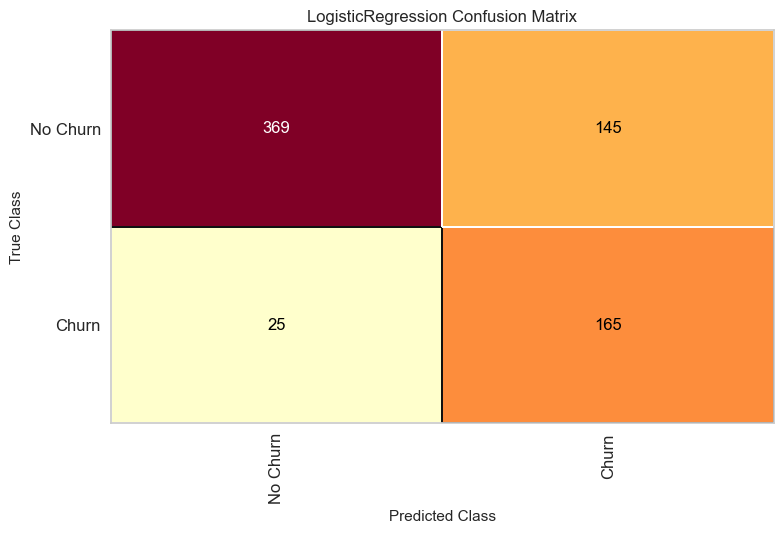

<Figure size 800x550 with 0 Axes>

In [13]:
# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

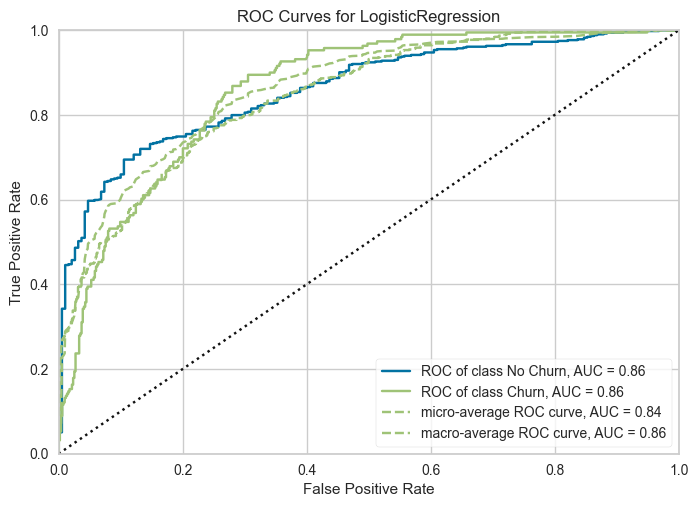

In [14]:
# # Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show();

## Test

AUC: 0.740
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       506
           1       0.52      0.76      0.62       199

    accuracy                           0.73       705
   macro avg       0.70      0.74      0.70       705
weighted avg       0.78      0.73      0.74       705



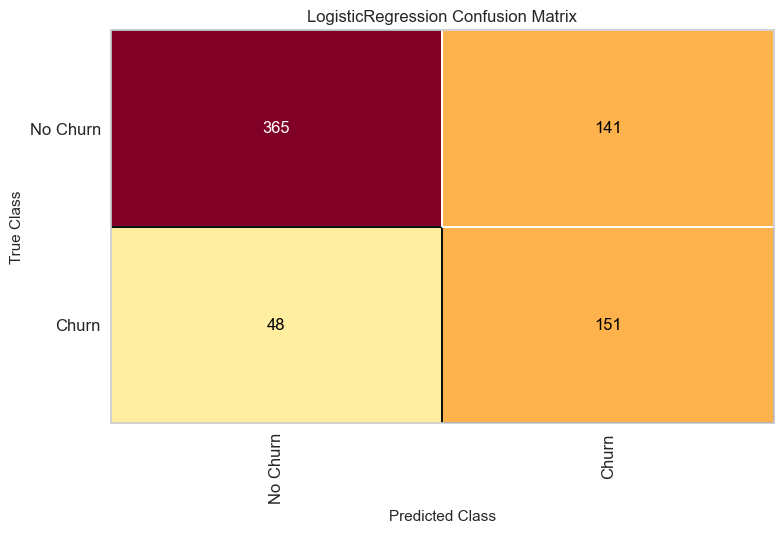

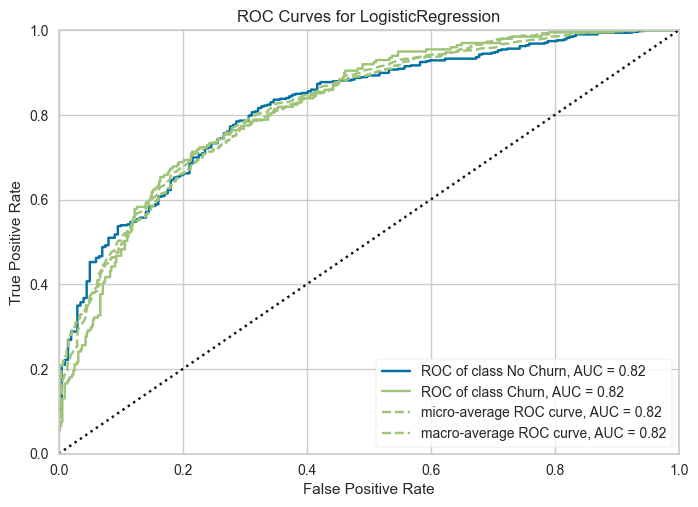

In [15]:
# Faz predições
y_pred = model_pipe.predict(X_test)
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_test, y_pred)
#Exibe as métricas 
print(f"AUC: {auc:.3f}",end="\n")
print(classification_report(y_test, y_pred))

# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_test, y_test,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

# Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show();

## Calculate ROI

In [16]:
# Loading...

## Deploy

In [18]:
with open(r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\models\model.pkl', 'wb') as f:
    joblib.dump(model_pipe, f)

In [19]:
with open(r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\models\model.pkl', 'rb') as f:
    model = joblib.load(f)

In [20]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', BinaryEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=300, random_state=42))])

# Test API server

In [26]:
import json
import requests

In [27]:
test_api = X_test.sample(2)
test_api = test_api.reset_index()

url = 'http://127.0.0.1:5000/predict'
request_data = json.dumps(test_api.to_dict(orient='records'))
header = {'Content-type': 'application/json' } 
response = requests.post(url, request_data, headers=header)
print(f'Status Code: {response.status_code}')
print(response.text)

Status Code: 200
[{"customerID": "4732-RRJZC", "SeniorCitizen": "No", "Partner": "Yes", "Dependents": "Yes", "tenure": 7, "MultipleLines": "No", "InternetService": "No", "OnlineSecurity": "No internet service", "OnlineBackup": "No internet service", "DeviceProtection": "No internet service", "TechSupport": "No internet service", "StreamingTV": "No internet service", "StreamingMovies": "No internet service", "Contract": "Month-to-month", "PaperlessBilling": "No", "PaymentMethod": "Mailed check", "MonthlyCharges": 20.25, "TotalCharges": 144.35, "Prediction": 0.28, "Prescription": "No Potential Churn"}, {"customerID": "8608-OZTLB", "SeniorCitizen": "No", "Partner": "Yes", "Dependents": "Yes", "tenure": 38, "MultipleLines": "No", "InternetService": "DSL", "OnlineSecurity": "Yes", "OnlineBackup": "Yes", "DeviceProtection": "Yes", "TechSupport": "Yes", "StreamingTV": "Yes", "StreamingMovies": "No", "Contract": "One year", "PaperlessBilling": "No", "PaymentMethod": "Electronic check", "Monthl

In [28]:
result_api = response.json()
df_result = pd.DataFrame(result_api)

In [29]:
df_result

,customerID,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Prediction,Prescription
0,4732-RRJZC,No,Yes,Yes,7,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.25,144.35,0.28,No Potential Churn
1,8608-OZTLB,No,Yes,Yes,38,No,DSL,Yes,Yes,Yes,Yes,Yes,No,One year,No,Electronic check,74.05,2802.30,0.14,No Potential Churn
